In [1]:
from __future__ import print_function, division, unicode_literals

import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def plot_image(image, shape=[28,28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    return

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min() # make the minimum == 0, so the padding looks white
    w, h = images.shape[1:]
    image = np.zeros(((w+pad) * n_rows + pad,
                     (h+pad) * n_cols + pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),
                  (x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")
    return

In [3]:
import numpy.random as rnd
rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[:100])

In [5]:
import tensorflow as tf

In [6]:
def show_reconstructed_digits(X, outputs, model_path = None,
                             n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
        
        fig = plt.figure(figsize=(8, 3 * n_test_digits))
        for digit_index in range(n_test_digits):
            plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
            plot_image(X_test[digit_index])
            plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
            plot_image(outputs_val[digit_index])

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./datasets/mnist1/")

Extracting ./datasets/mnist1/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist1/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist1/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist1/t10k-labels-idx1-ubyte.gz


## Variational Autoencoders

Another important category of autoencoders was introduced in 2014 by Diederik Kingma and Max Welling and has quickly become one of the most popular types of autoencoders: **variational autoencoders**.

They are quite different from all the autoencoders we have discussed so far, in particular:

* They are probabilistic autoencoders, meaning that their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which use randomness only during training).

* Most importantly, they are generative autoencoders, meaning that they can generate new instances that look like they were sampled from the training set.

Both these properties make them rather similar to RBMs, but they are easier to train and the sampling process is much faster (with RBMs you need to wait for the network to stabilize into a “thermal equilibrium” before you can sample a new instance).

Let’s take a look at how they work. Figure (left) shows a variational autoencoder. You can recognize, of course, the basic structure of all autoencoders, with an encoder followed by a decoder (in this example, they both have two hidden layers), but there is a twist: instead of directly producing a coding for a given input, _the encoder produces a mean coding μ and a standard deviation σ_. The actual coding is then sampled randomly from a Gaussian distribution with mean μ and standard deviation σ. After that the decoder just decodes the sampled coding normally. The right part of the diagram shows a training instance going through this autoencoder. First, the encoder produces μ and σ, then a coding is sampled randomly (notice that it is not exactly located at μ), and finally this coding is decoded, and the final output resembles the training instance.

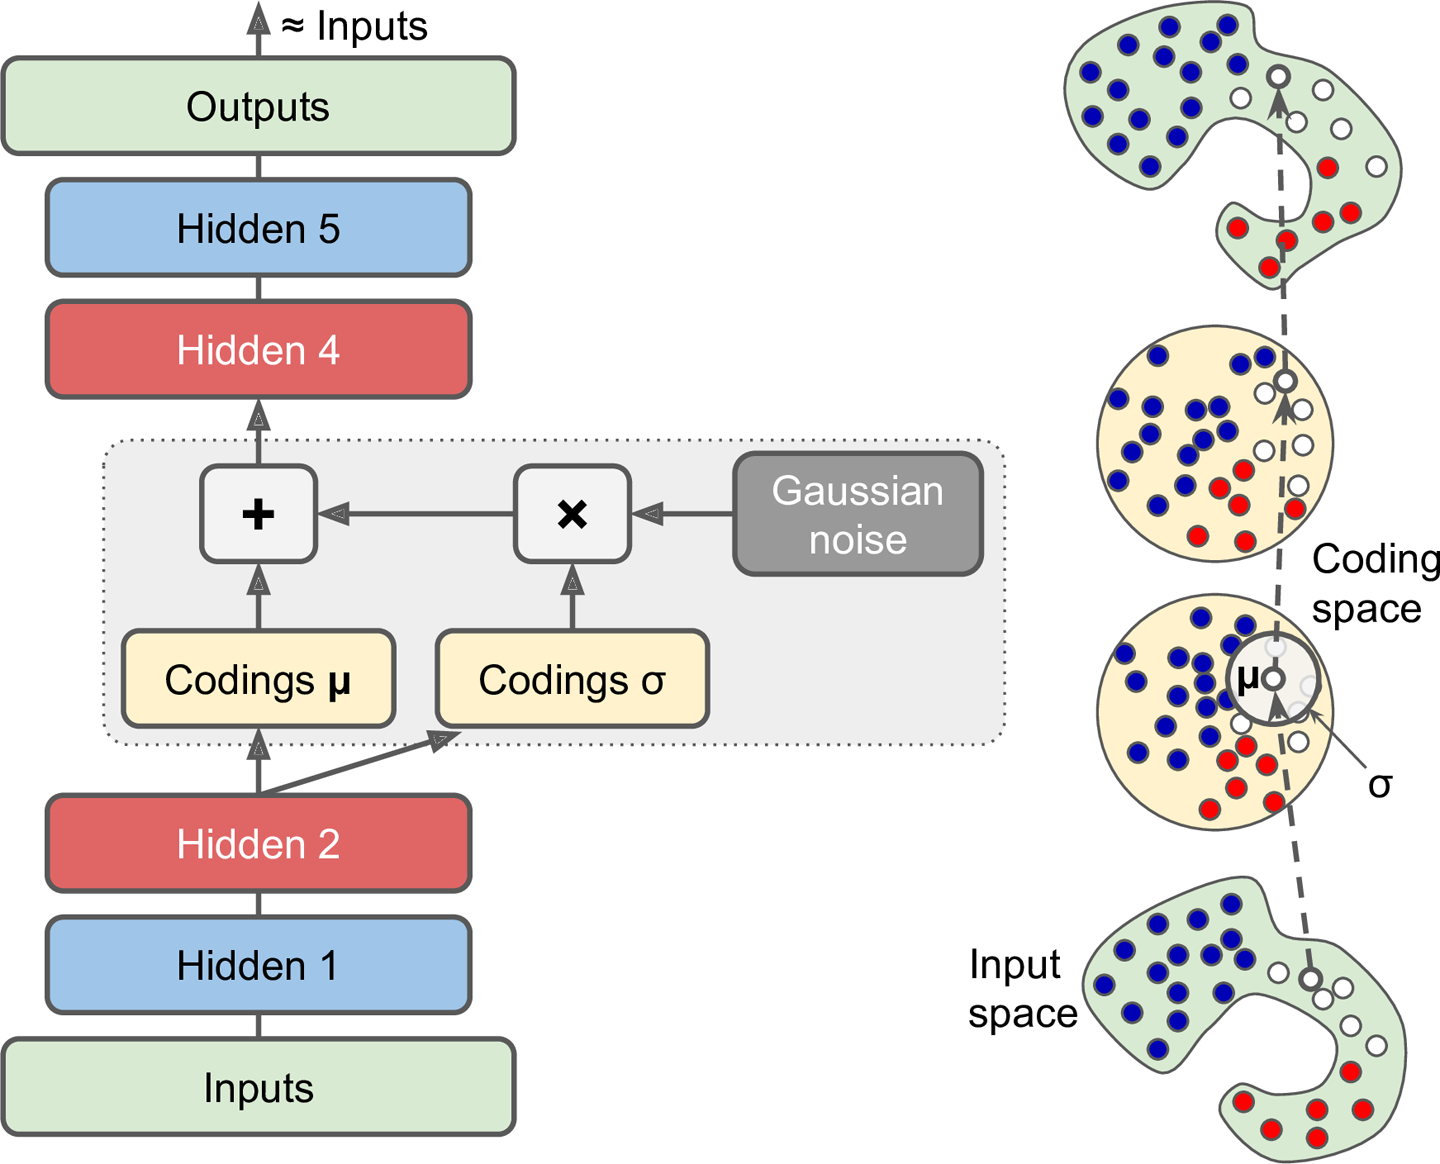

As you can see on the diagram, although the inputs may have a very convoluted distribution, a variational autoencoder tends to produce codings that look as though they were sampled from a simple Gaussian distribution: during training, the cost function (discussed next) pushes the codings to gradually migrate within the coding space (also called the latent space) to occupy a roughly (hyper)spherical region that looks like a cloud of Gaussian points. One great consequence is that after training a variational autoencoder, you can very easily generate a new instance: just sample a random coding from the Gaussian distribution, decode it, and voilà!<br/>

So let’s look at the cost function. It is composed of two parts. The first is the usual reconstruction loss that pushes the autoencoder to reproduce its inputs (we can use cross entropy for this, as discussed earlier).<br/>The second is the latent loss that pushes the autoencoder to have codings that look as though they were sampled from a simple Gaussian distribution, for which we use the KL divergence between the target distribution (the Gaussian distribution) and the actual distribution of the codings.<br/>The math is a bit more complex than earlier, in particular because of the Gaussian noise, which limits the amount of information that can be transmitted to the coding layer (thus pushing the autoencoder to learn useful features). Luckily, the equations simplify to the following code for the latent loss:

```python
eps = 1e-10  # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(tf.square(hidden3_sigma) + tf.square(hidden3_mean) - 1 - tf.log(eps + tf.square(hidden3_sigma)))
```
One common variant is to train the encoder to output $\gamma = \log(\sigma^{2})$ rather than $\sigma$. Whenever we need $\sigma$ we can just compute $\sigma = \mathcal{exp}(\frac{\gamma}{2})$. This makes it a bit easier for the encoder to capture sigmas of different scales, and thus it helps speed up convergence. The latent loss ends up a bit simpler:

```python
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
```

In [8]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20 # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(tf.layers.dense,
                        activation=tf.nn.relu,
                        kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [9]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [10]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [11]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

09% Train total loss: 22902.5 	Reconstruction loss: 20208.1 	Latent loss: 2694.44
19% Train total loss: 20772.1 	Reconstruction loss: 18010.0 	Latent loss: 2762.12
29% Train total loss: 22587.1 	Reconstruction loss: 19793.0 	Latent loss: 2794.18
39% Train total loss: 20569.9 	Reconstruction loss: 17845.1 	Latent loss: 2724.82
49% Train total loss: 18764.9 	Reconstruction loss: 16044.3 	Latent loss: 2720.62
59% Train total loss: 17865.2 	Reconstruction loss: 14769.3 	Latent loss: 3095.97
69% Train total loss: 18997.2 	Reconstruction loss: 16011.5 	Latent loss: 2985.66
79% Train total loss: 18462.7 	Reconstruction loss: 15393.3 	Latent loss: 3069.33
89% Train total loss: 18763.7 	Reconstruction loss: 15849.4 	Latent loss: 2914.29
9 Train total loss: 19638.8 	Reconstruction loss: 16697.7 	Latent loss: 2941.14
10% Train total loss: 17354.1 	Reconstruction loss: 14481.8 	Latent loss: 2872.34
11% Train total loss: 17302.1 	Reconstruction loss: 14479.1 	Latent loss: 2822.95
12% Train total lo

In [12]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Generate digits

Now let’s use this variational autoencoder to generate images that look like handwritten digits. All we need to do is train the model, then sample random codings from a Gaussian distribution and decode them.

In [13]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

09% Train total loss: 18377.9 	Reconstruction loss: 14536.0 	Latent loss: 3841.9
19% Train total loss: 16910.9 	Reconstruction loss: 13173.5 	Latent loss: 3737.44
2 Train total loss: 16566.1 	Reconstruction loss: 12755.5 	Latent loss: 3810.54
39% Train total loss: 16934.9 	Reconstruction loss: 13078.7 	Latent loss: 3856.13
49% Train total loss: 16123.4 	Reconstruction loss: 12357.2 	Latent loss: 3766.22
59% Train total loss: 16231.4 	Reconstruction loss: 12388.3 	Latent loss: 3843.16
69% Train total loss: 16377.4 	Reconstruction loss: 12469.8 	Latent loss: 3907.64
79% Train total loss: 16107.3 	Reconstruction loss: 12300.2 	Latent loss: 3807.05
8 Train total loss: 15597.9 	Reconstruction loss: 11844.8 	Latent loss: 3753.08
99% Train total loss: 15313.9 	Reconstruction loss: 11682.6 	Latent loss: 3631.23
10% Train total loss: 15794.6 	Reconstruction loss: 12004.6 	Latent loss: 3790.01
11% Train total loss: 15670.2 	Reconstruction loss: 11866.4 	Latent loss: 3803.8
12 Train total loss: 1

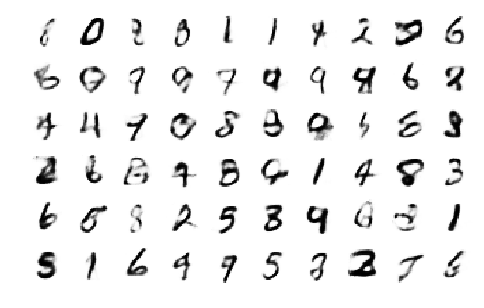

In [14]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

Saving figure generated_digits_plot


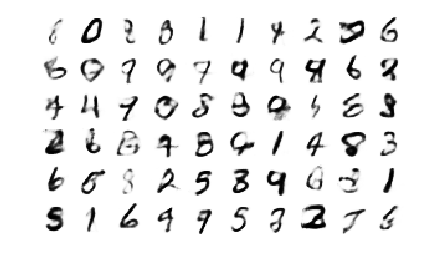

In [15]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
save_fig("generated_digits_plot")
plt.show()

Note that the latent loss is computed differently in this second variant:

In [16]:
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

## Encode & Decode

Encode:

In [17]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

Decode:

In [18]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

Let's plot the reconstructions:

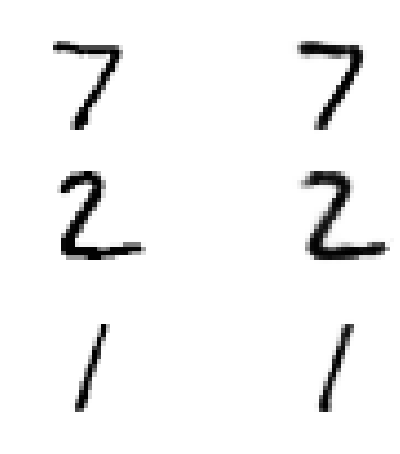

In [19]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

## Interpolate digits

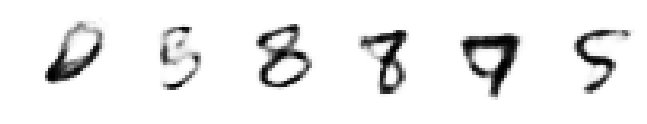

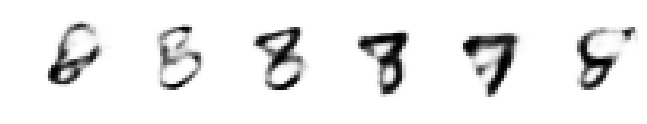

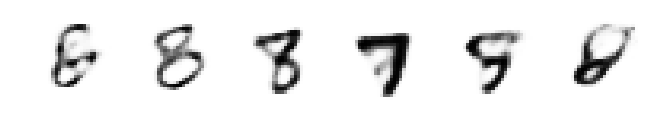

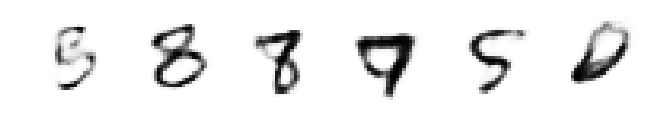

In [20]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()